# Standard Supervised Learning (No PCA)

In [1]:
import numpy as np
import pandas as pd

import datetime

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

Notebook last run (end-to-end): 2025-02-04 21:46:04.850172


In [2]:
df = pd.read_csv("../data/high_diamond_ranked_10min.csv")

# See 0 Exploratory Analysis notebook for reasoning
drop_columns = ['gameId', 'blueEliteMonsters', 'redEliteMonsters', 'redGoldDiff', 'redExperienceDiff', 'redFirstBlood', 'redDeaths', 'blueDeaths']
df = df.drop(columns=drop_columns)
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,...,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,11,0,0,0,17210,...,0,0,0,16567,6.8,17047,197,55,19.7,1656.7
1,0,12,1,0,5,5,0,0,0,14712,...,1,1,1,17620,6.8,17438,240,52,24.0,1762.0
2,0,15,0,0,7,4,1,0,0,16113,...,0,0,0,17285,6.8,17254,203,28,20.3,1728.5
3,0,43,1,0,4,5,0,1,0,15157,...,0,0,0,16478,7.0,17961,235,47,23.5,1647.8
4,0,75,4,0,6,6,0,0,0,16400,...,1,0,0,17404,7.0,18313,225,67,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,5,1,0,0,17765,...,0,0,0,15246,6.8,16498,229,34,22.9,1524.6
9875,1,54,0,0,6,8,1,0,0,16238,...,0,0,0,15456,7.0,18367,206,56,20.6,1545.6
9876,0,23,1,0,6,5,0,0,0,15903,...,1,0,0,18319,7.4,19909,261,60,26.1,1831.9
9877,0,14,4,1,2,3,1,0,0,14459,...,0,0,0,15298,7.2,18314,247,40,24.7,1529.8


In [3]:
print(f"Number of features (columns): {len(df.columns)}")
print(f"Number of samples (rows): {len(df)}")

Number of features (columns): 32
Number of samples (rows): 9879


### Setting Expectations: Missing Features and Expected Accuracy

We don't have data about individual champions on each team (or champion's winrate), information about each player's ELO (which has surprisingly high variance), information about how long each player was in game (a player who connects late or disconnects early will obviously have a huge influence on the game), or even more granular data like player positions or item purchases. Predicting games based on data like player movement and item buys would likely be difficult (especially without enormous amounts of data). Predictions based on team composition is out of the question, with so many possible different team combinations (and team matchups) that getting even one game per possible combination of champions would require astronomical amounts of data. None of this data is available without making additional queries to Riot's API, so this is all to say these features would probably not be useful even if we did know them.

However, we are lacking three major pieces of data.
1. We don't have information beyond the first ten minutes of each game. Both of these have enormous impacts on target accuracy for our model and the kinds of models we can train. As for having only ten minutes of data, this means we're only seeing the very beginnings of the game, while it's still in the first phase ("laning phase"). This means we are only able to predict game outcomes based on very early leads. However, team performance is not time homogenous, like in football: a football team scoring does not make it any easier or harder for them to score, so we could reasonably model football goals as independent. However, a player in League of Legends dying or performing poorly puts them at a disadvantage, increasingly the likelihood that they will continue to do poorly. This is good news for us: not only does performance in the first ten minutes predict player skill which predicts win likelihood, it actually predicts the likelihood of a team continuing to do poorly and eventually losing. Of course, by design there are frequent opportunities for teams to claw their way back into the game and make up for earlier disadvantages. We can conclude that the first ten minutes provides an imperfect but reasonably predictive window into a particular game.
2. Second, and the data we do have access to is not time series data. Having time series data would provide substantially more information into the game state: for example, all players on one team dying at the same time, or one player dying right before an objective spawns on the map, is devastating compared to dying individually at different times or dying at an relatively inconsequential time. However, time series data might also be substantially trickier to analyze accurately given the highly non-independent nature of events such as deaths, towers, gold, elite monsters, and so on. Furthermore, if we did have access to champions picks for each team, the winrates of each champion changes over time (as do many other aspects of the game) as some champions use game resources more effectively than others at certain points in the game.
3. We don't have any access to the distribution of resources. Resources like gold and experience are not shared across teams: one player on a team might have a lot of resources, and another might have very few. A single player getting a large resource lead is very different from a whole team get a moderate but evenly distributed lead. This, combined with champion data (some of which obtain or use resources better or worse than others), would vastly improve model accuracy and better identify games where one team can run away with a lead. Resource lead also can't tell us how well a team uses resources, or how many resources they need to succeed: some games that have 0 gold difference may strongly favor one team over another.  

In light of all this, I would consider accurate above 85% to be highly suspect and likely an indication of overfitting or some kind of bias. On the other hand, the information we do have should allow us to do substantially better than a coin flip: any worse than 65% would be disappointing. To summarize, **our target accuracy is between 65-85%.**

# Supervised Learning

### Train Test Split

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

y = df['blueWins']
X = df.drop(columns=['blueWins'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = X_train_scaler.transform(X_train)

### Logistic Regression

In [5]:
from sklearn import linear_model

reg = linear_model.LogisticRegression()

reg.fit(X_train_scaled, y_train)

logistic_regression_accuracy = accuracy_score(y_test, reg.predict(X_test))

print(f"Accuracy of logistic regression: {logistic_regression_accuracy:.3f}")

Accuracy of logistic regression: 0.685


/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Linear Discriminant Analysis

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
lda_accuracy = accuracy_score(y_test, lda.predict(X_test))
print(f"Accuracy of linear discriminant analysis: {lda_accuracy:.3f}")

Accuracy of linear discriminant analysis: 0.690


/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(


### Quadratic Discriminant Analysis

In [7]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
qda_accuracy = accuracy_score(y_test, qda.predict(X_test))
print(f"Accuracy of quadratic discriminant analysis: {qda_accuracy:.3f}")

Accuracy of quadratic discriminant analysis: 0.503


/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
  warnings.warn(


In [8]:
# Covariance matrix of class 0 and 1 aren't full, so try increasing regularization
qda = QuadraticDiscriminantAnalysis(reg_param=1)
qda.fit(X_train_scaled, y_train)
qda_accuracy = accuracy_score(y_test, qda.predict(X_test))
print(f"Accuracy of quadratic discriminant analysis with regularization: {qda_accuracy:.3f}")

/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
  warnings.warn(


Accuracy of quadratic discriminant analysis with regularization: 0.729


Regularization parameters from $0.1, 0.2, ..., 1.0$ yielded much better accuracy, capping out at $1.0$. So far, QDA is our **most accurate model**!

### Support Vector Machine

In [9]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train_scaled, y_train)
svm_accuracy = accuracy_score(y_test, clf.predict(X_test))
print(f"Accuracy of support vector machine: {svm_accuracy:.3f}")

/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Accuracy of support vector machine: 0.503


SVM accuracy is really terrible -- basically a coin flip!

### Artifical Neural Nets

In [10]:
# Set random seed
import tensorflow as tf
tf.random.set_seed(42)

2025-02-04 21:46:07.911405: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 21:46:07.920898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738723567.930221  114673 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738723567.933335  114673 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 21:46:07.943310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [11]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
history = model_1.fit(X_train, y_train, epochs=20, verbose=1)
loss, accuracy = model_1.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/20


2025-02-04 21:46:09.149515: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5047 - loss: nan      
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 12/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 

In [12]:
# First model had NaN loss, maybe learning rate is too low
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate=0.02), metrics=['accuracy'])
history = model_2.fit(X_train, y_train, epochs=20, verbose=1)
loss, accuracy = model_2.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5015 - loss: nan     
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.5028 - loss: nan
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.5028 - loss: nan
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.5028 - loss: nan
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan  
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan  
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan  
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan  
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan  
Epoch 12/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

In [13]:
# Adjusting learning rate did nothing, try Adam
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model_3.fit(X_train, y_train, epochs=20, verbose=1)
loss, accuracy = model_3.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.6532 - loss: 226.8609
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6316 - loss: 21.8210
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6313 - loss: 27.1501
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 27.4810  
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.6133 - loss: 33.8277
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.6468 - loss: 19.5716
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.6357 - loss: 20.7813
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6524 - loss: 13.8981
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6401 - loss: 17.3708 
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6339 - loss: 15.9706
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6342 - loss: 20.8460
Epoch 12/20
247/247 ━━━━━━━

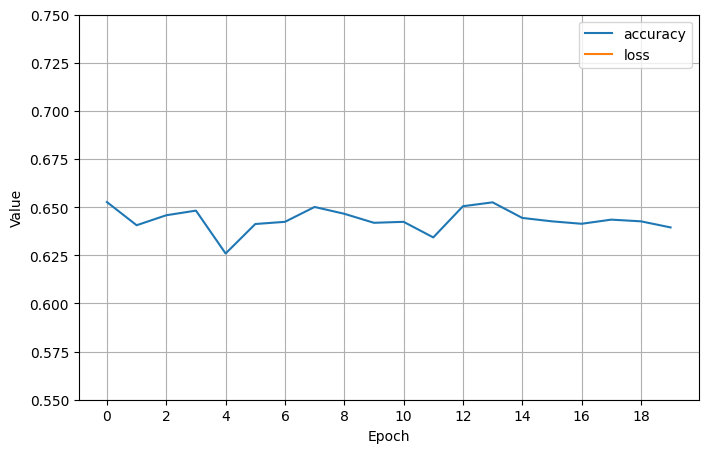

In [15]:
# We now have actual loss, so let's plot it
import seaborn as sns
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 20, 2.0))
plt.show()


In [16]:
# See if accuracy increases with more epochs
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model_4.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_4.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5840 - loss: 1165.1456  
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6305 - loss: 20.7059
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6340 - loss: 22.8349
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6360 - loss: 23.2775
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6441 - loss: 17.3032
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6481 - loss: 16.8346
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 16.2673
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6466 - loss: 15.3068
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6393 - loss: 15.4413
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6478 - loss: 14.6655
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6469 - loss: 20.6664
Epoch 12/100
247/247 ━━━━━

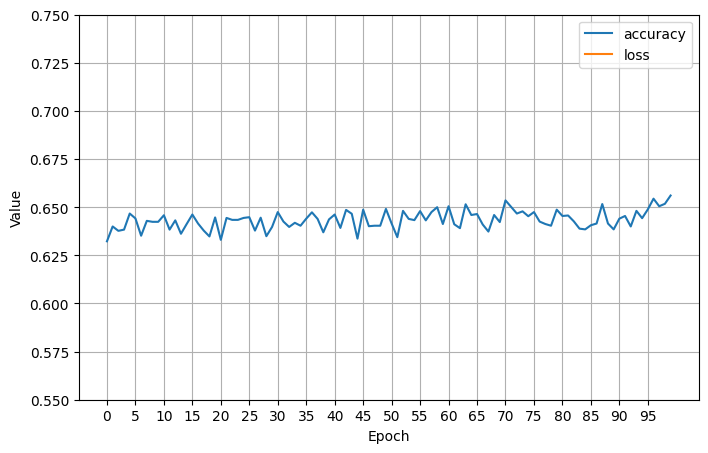

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [18]:
# See if accuracy increases with additional nonlinear layers
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model_4.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_4.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6089 - loss: 371.2016
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6415 - loss: 13.9432
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6522 - loss: 15.3465
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6386 - loss: 8.8188
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6439 - loss: 7.9146
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6291 - loss: 5.0190
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6500 - loss: 6.6115
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6475 - loss: 4.2706
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6569 - loss: 3.7038
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6391 - loss: 3.8854
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6527 - loss: 2.9483
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━

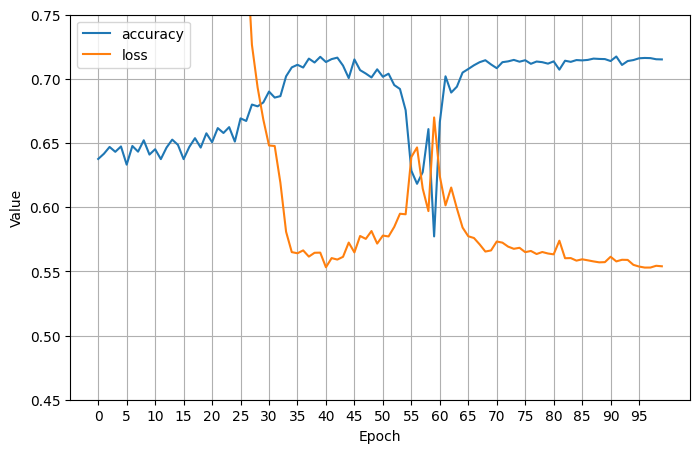

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.45, 0.75) # adjust y-axis to see full range
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [20]:
# Accuracy increased then decreased. See if smaller learning rate helps
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model_5.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_5.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6440 - loss: 260.8935
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6293 - loss: 12.0602
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6362 - loss: 10.7479
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6514 - loss: 7.6731
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6339 - loss: 6.4138
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6435 - loss: 3.9147
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6396 - loss: 4.1466
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6424 - loss: 3.2308
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6471 - loss: 2.6684
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6329 - loss: 2.0201
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6414 - loss: 1.9327
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━

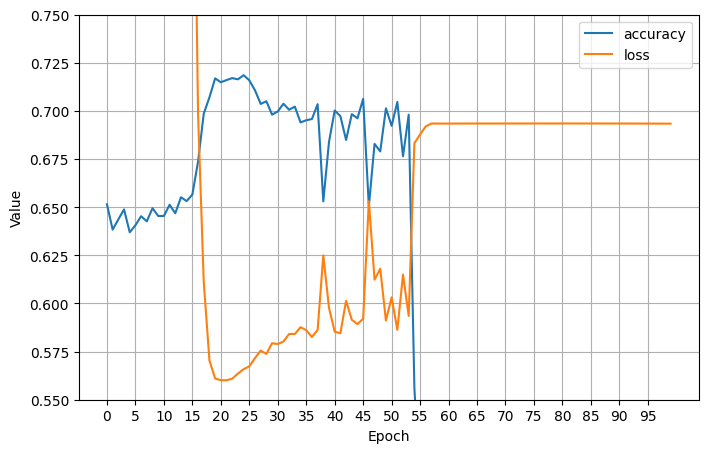

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [22]:
# See if even smaller learning rate helps
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_6.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_6.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5735 - loss: 747.9064
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 17.4185
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6447 - loss: 14.9937
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6420 - loss: 15.3796
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6387 - loss: 13.0468
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6169 - loss: 15.0785
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6255 - loss: 10.3849
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6410 - loss: 16.1427
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6043 - loss: 15.6339
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6400 - loss: 11.8904
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6380 - loss: 12.0222
Epoch 12/100
247/247 ━━━━━━━━

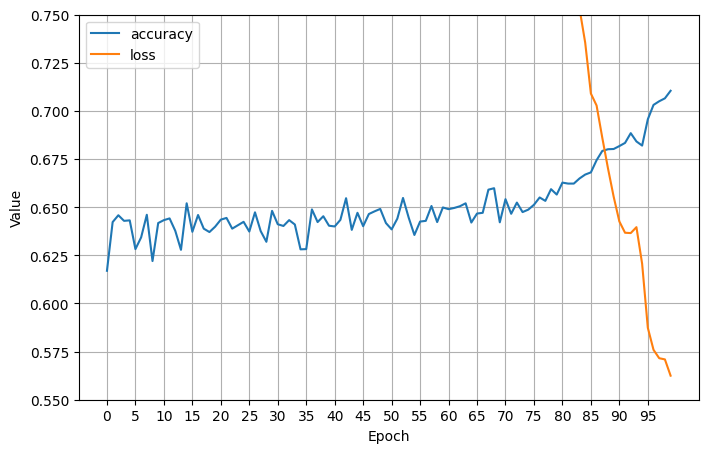

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [24]:
# The model accuracy seems to be approaching maximum we would expect with only ten minutes of data
# But let's try more neurons and see if that improves accuracy
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(50),
  tf.keras.layers.Dense(50),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_7.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_7.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6202 - loss: 268.6806
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6453 - loss: 23.3497
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6282 - loss: 19.7259
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6342 - loss: 11.8773
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6464 - loss: 13.3024
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6406 - loss: 11.2752
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6369 - loss: 11.0266
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6356 - loss: 9.1333
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6527 - loss: 8.4395
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6497 - loss: 6.3928
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6424 - loss: 6.1449
Epoch 12/100
247/247 ━━━━━━━━━━━━

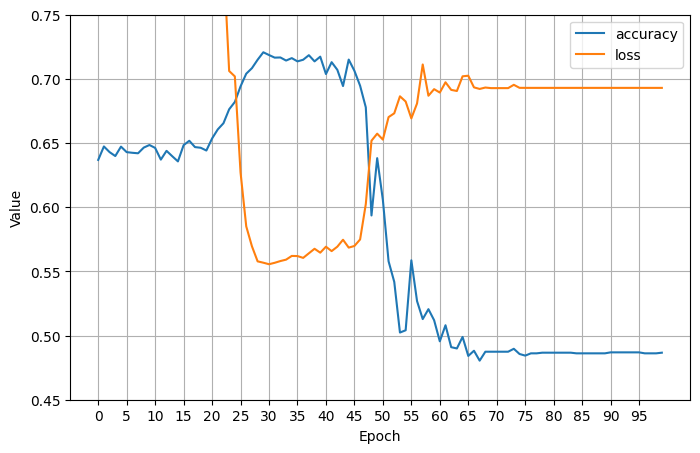

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.45, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [26]:
# That was terrible! See if different layers help instead
model_8 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_8.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_8.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5935 - loss: 22.9303
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6467 - loss: 2.0595
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6458 - loss: 1.6188
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6230 - loss: 2.2922
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6458 - loss: 1.4328
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6457 - loss: 1.2308
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6420 - loss: 1.6670
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6546 - loss: 1.1910
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6278 - loss: 1.3193
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6577 - loss: 0.9698
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6386 - loss: 1.1386
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━━━━

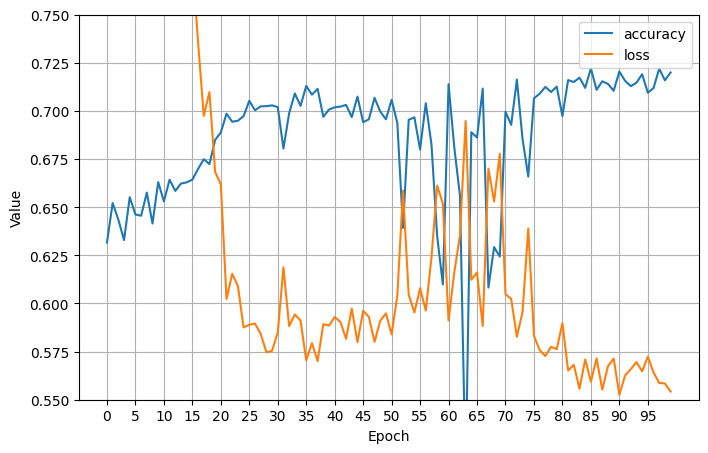

In [27]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

The model accuracy seems to level off around .725% training accuracy, and achieves the same test accuracy, so it's very unlikely that we've overfitted. This is the **second best model**, only slightly underperforming QDA.

In [28]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-02-04 21:54:46.460380 (duration: 0:08:41.610208)
